In [1]:
# importing dependencies
from datetime import datetime
import os
from pathlib import Path
import pickle
import numpy as np
import qlib
from qlib.config import REG_CN
from qlib.utils import init_instance_by_config
from qlib.workflow import R
from qlib.workflow.record_temp import SignalRecord, SigAnaRecord, PortAnaRecord
from qlib.contrib.model.pytorch_master_ts import MASTERModel
from qlib.contrib.data.dataset import MASTERTSDatasetH
from qlib.contrib.data.handler import Alpha158
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from qlib.utils import exists_qlib_data
from qlib.tests.data import GetData


provider_uri = "~/QuantProject/.qlib/qlib_data/cn_data"  # target_dir
if not exists_qlib_data(provider_uri):
    print(f"Qlib data is not found in {provider_uri}")
    GetData().qlib_data(target_dir=provider_uri, region=REG_CN)
qlib.init(provider_uri=provider_uri, region=REG_CN)

[1842354:MainThread](2025-04-07 20:35:29,595) INFO - qlib.Initialization - [config.py:420] - default_conf: client.
[1842354:MainThread](2025-04-07 20:35:29,601) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[1842354:MainThread](2025-04-07 20:35:29,603) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': PosixPath('/home/24039378g/QuantProject/.qlib/qlib_data/cn_data')}


In [11]:
market = "csi300"
benchmark = "SH000300"

# 配置参数
market = "csi300"
benchmark = "SH000300"

# 数据处理器配置
data_handler_config = {
    "start_time": "2008-01-01",
    "end_time": "2020-08-01",
    "fit_start_time": "2008-01-01",
    "fit_end_time": "2014-12-31",
    "instruments": market,
    "infer_processors": [
        {
            "class": "RobustZScoreNorm",
            "kwargs": {
                "fields_group": "feature",
                "clip_outlier": True
            }
        },
        {
            "class": "Fillna",
            "kwargs": {
                "fields_group": "feature"
            }
        }
    ],
    "learn_processors": [
        {"class": "DropnaLabel"},
        {
            "class": "CSRankNorm",
            "kwargs": {
                "fields_group": "label"
            }
        }
    ],
    # "label": ["Ref($close, -5) / Ref($close, -1) - 1"]
}

market_data_handler_config = {
    "start_time": "2008-01-01",
    "end_time": "2020-08-01",
    "fit_start_time": "2008-01-01",
    "fit_end_time": "2014-12-31",
    "instruments": market,
    "infer_processors": [
        {
            "class": "RobustZScoreNorm",
            "kwargs": {
                "fields_group": "feature",
                "clip_outlier": True
            }
        },
        {
            "class": "Fillna",
            "kwargs": {
                "fields_group": "feature"
            }
        }
    ]
}

# 模型配置
model_config = {
    "class": "MASTERModel",
    "module_path": "qlib.contrib.model.pytorch_master_ts",
    "kwargs": {
        "seed": 0,
        "n_epochs": 1,
        "lr": 0.000008,
        "train_stop_loss_thred": 0.95,
        "market": market,
        "benchmark": benchmark,
        "save_prefix": market
    }
}

# 数据集配置
dataset_config = {
    "class": "MASTERTSDatasetH",
    "module_path": "qlib.contrib.data.dataset",
    "kwargs": {
        "handler": {
            "class": "Alpha158",
            "module_path": "qlib.contrib.data.handler",
            "kwargs": data_handler_config
        },
        "segments": {
            "train": ["2008-01-01", "2014-12-31"],
            "valid": ["2015-01-01", "2016-12-31"],
            "test": ["2017-01-01", "2020-08-01"]
        },
        "step_len": 8,
        "market_data_handler_config": market_data_handler_config
    }
}

task = {"model": model_config,"dataset": dataset_config}

dataset = init_instance_by_config(dataset_config)
model = init_instance_by_config(model_config)

[1842354:MainThread](2025-04-07 20:50:51,875) INFO - qlib.timer - [log.py:127] - Time cost: 9.194s | Loading data Done
/home/24039378g/.conda/envs/MASTER/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
[1842354:MainThread](2025-04-07 20:50:56,924) INFO - qlib.timer - [log.py:127] - Time cost: 4.556s | RobustZScoreNorm Done
[1842354:MainThread](2025-04-07 20:50:57,533) INFO - qlib.timer - [log.py:127] - Time cost: 0.606s | Fillna Done
[1842354:MainThread](2025-04-07 20:50:57,942) INFO - qlib.timer - [log.py:127] - Time cost: 0.218s | DropnaLabel Done
/home/24039378g/QuantProject/QLIB/qlib/data/dataset/processor.py:370: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index


模型参数量统计:
--------------------------------------------------
特征门控层 (Gate): 10,112 参数
输入映射层 (x2y): 40,704 参数
时间注意力层 (TAttention): 329,216 参数
空间注意力层 (SAttention): 329,216 参数
时序注意力层 (TemporalAttention): 65,536 参数
解码器 (Decoder): 257 参数
--------------------------------------------------
总参数量: 775,041


In [13]:
# preview the data
data = dataset.prepare("test")  # 检查训练集数据  
data.head()

MergeError: Not allowed to merge between different levels. (1 levels on the left, 2 on the right)

In [15]:
# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# model_name = f"{market}{model_config["class"]}_0"
from qlib.utils import flatten_dict


model_name = f"csi300master_3"
model_file_path = Path(f"./model/{model_name}.pkl")

if not os.path.exists('./model'):
    os.makedirs('./model')
    
with R.start(experiment_name="train_model"):
    if not model_file_path.exists():
        try:
            # R.log_params(**model_config["kwargs"])
            R.log_params(**flatten_dict(task))
            # print("文件列表:", list(R.get_recorder().list_artifacts()))
            
            # 方法1：使用 sys.stdout.write
            def custom_print(*args, **kwargs):
                msg = ' '.join(map(str, args)) + '\n'
                import sys
                sys.stdout.write(msg)
            
            # 临时替换 print
            import builtins
            orig_print = builtins.print
            builtins.print = custom_print
        
            model.fit(dataset)  # 训练模型
            R.save_objects(trained_model=model)
            
        finally:
            builtins.print = orig_print  # 确保恢复原始 print
            # pkl_path = os.path.join("./model", f"{model_name}.pkl")
            # with open(pkl_path, "wb") as f:
            #     pickle.dump(model, f)
            # 在master model里有一个生成函数
        
    else:
        model.load_model(f"./model/{model_name}.pkl")
        R.save_objects(trained_model=model)
        
    rid = R.get_recorder().id

[1842354:MainThread](2025-04-07 21:15:00,162) INFO - qlib.workflow - [exp.py:258] - Experiment 566184983307789232 starts running ...
[1842354:MainThread](2025-04-07 21:15:00,229) INFO - qlib.workflow - [recorder.py:345] - Recorder e0bd5db5713545c4aa40b34a8b9d4736 starts running under Experiment 566184983307789232 ...


[1842354:MainThread](2025-04-07 21:15:00,395) INFO - qlib.timer - [log.py:127] - Time cost: 0.000s | waiting `async_log` Done


In [16]:
from qlib.data import D

# 获取SH600000的收盘价数据
close_data = D.features(["SH600000"], ["$close"], 
                       start_time="2017-01-01", 
                       end_time="2020-08-01")

# 转换为单列Series并去除instrument层级
close_series = close_data.droplevel("instrument")["$close"]
print(close_series.head())

datetime
2017-01-03    8.819036
2017-01-04    8.835212
2017-01-05    8.819036
2017-01-06    8.754115
2017-01-09    8.764877
Name: $close, dtype: float32


In [33]:
import matplotlib.pyplot as plt  

# 提取数据  
# data = dataset.prepare("test")  # 从 DatasetH 获取数据  
data = dataset.prepare("test", col_set="label", only_label=True)  # 从 DatasetH 获取数据  
data = data.idx_df  # 获取底层 DataFrame 格式  
# 检查数据结构  
print(data.head())  # 检查前几行  
print(data.columns)  # 检查列名  
print(data.index.names)  # 如果有多层索引，检查索引层级名称  

# 如果 `stock` 在索引中，重设置索引为普通列  
if "stock" not in data.columns:  
    if "stock" in data.index.names:  # 如果在索引中  
        data = data.reset_index()  # 将索引转成普通列  
    else:  
        raise KeyError("Column or index 'stock' not found in the dataset")  

# 按股票代码筛选 SH600000 数据  
sh600000_data = data[data["stock"] == "SH600000"]  

# 确保时间列为日期格式  
sh600000_data["time"] = pd.to_datetime(sh600000_data["time"])  
sh600000_data = sh600000_data.sort_values(by="time")  # 按时间排序  

# 可视化  
import matplotlib.pyplot as plt  

plt.figure(figsize=(12, 6))  
plt.plot(sh600000_data["time"], sh600000_data["close"], label="Close Price - SH600000")  
plt.title("Close Price of SH600000 Over Time")  
plt.xlabel("Time")  
plt.ylabel("Close Price")  
plt.legend()  
plt.grid()  
plt.show()    

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(14, 7))

# 主价格曲线
plt.plot(close_series, 
        label="Close Price", 
        color="#1f77b4", 
        linewidth=2)

# 增强可视化元素
plt.title("SH600000 Close Price Trend (2017-2020)", 
         fontsize=16, pad=20)
plt.ylabel("Price (CNY)", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# 添加关键点位标注
max_price = close_series.idxmax()
min_price = close_series.idxmin()
plt.scatter([max_price, min_price], 
           [close_series[max_price], close_series[min_price]],
           color=['red', 'green'], 
           s=100, zorder=5)
plt.annotate(f'Max: {close_series[max_price]:.2f}', 
            xy=(max_price, close_series[max_price]),
            xytext=(15, 15), 
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->"))
plt.annotate(f'Min: {close_series[min_price]:.2f}', 
            xy=(min_price, close_series[min_price]),
            xytext=(15, -25), 
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->"))

# 优化X轴显示
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# 计算移动平均
close_df = close_series.to_frame("close")
close_df["30d_MA"] = close_df["close"].rolling(30).mean()
close_df["60d_MA"] = close_df["close"].rolling(60).mean()

# 绘制带均线的图表
plt.figure(figsize=(14, 7))
plt.plot(close_df["close"], label="Daily Close", alpha=0.5)
plt.plot(close_df["30d_MA"], label="30-day MA", linewidth=2)
plt.plot(close_df["60d_MA"], label="60-day MA", linewidth=2)

# 金叉/死叉标记
cross_points = close_df[close_df["30d_MA"].gt(close_df["60d_MA"]) & 
                       close_df["30d_MA"].shift(1).le(close_df["60d_MA"].shift(1))]
for date, row in cross_points.iterrows():
    plt.scatter(date, row["close"], color='gold', s=100, 
               edgecolors='black', label='Golden Cross' if date == cross_points.index[0] else "")

plt.title("SH600000 with Moving Averages")
plt.legend()
plt.show()

In [14]:
from qlib.data import D
import matplotlib.pyplot as plt
import pandas as pd

# 获取SH600000数据
def get_single_stock_data(symbol):
    # 获取实际值
    actual = D.features([symbol], ["$close"], "2017-01-01", "2020-08-01")
    actual = actual.droplevel('instrument')['$close']
    
    # 获取预测值（需先运行模型预测）
    pred = R.get_recorder().load_object("pred.pkl")
    pred = pred.xs(symbol, level='instrument')['score']
    
    return pd.concat([actual.rename('actual'), pred.rename('pred')], axis=1)

sh600000_data = get_single_stock_data("SH600000").dropna()

[1842354:MainThread](2025-04-07 21:09:49,577) WARNING - qlib.workflow - [exp.py:308] - Please make sure the recorder name mlflow_recorder is unique, we will only return the latest recorder if there exist several matched the given name.


LoadObjectError: No such file or directory: '/home/24039378g/QuantProject/QLIB/examples/mlruns/344134119280035007/8d15c96a9365469a98626ed3f10d5620/artifacts/pred.pkl'

Loaded 4943 trading days for the 'day' frequency.
First 5 trading days: [Timestamp('1999-11-10 00:00:00') Timestamp('1999-11-11 00:00:00')
 Timestamp('1999-11-12 00:00:00') Timestamp('1999-11-15 00:00:00')
 Timestamp('1999-11-16 00:00:00')]
SH600000 available data range: ('SH600000', Timestamp('1999-11-10 00:00:00')) to ('SH600000', Timestamp('2020-09-25 00:00:00'))


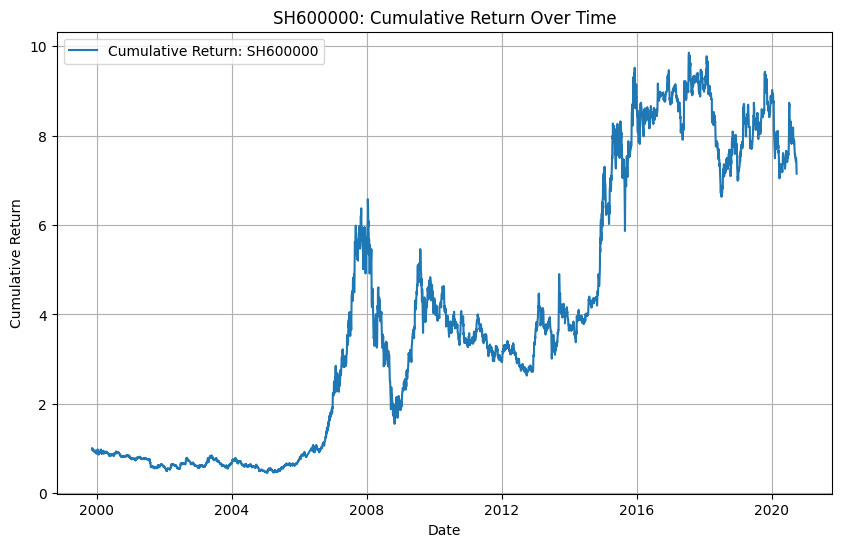

In [12]:
import qlib  
from qlib.data import D  
import os  

# 初始化 Qlib  
# provider_uri = "~/QuantProject/.qlib/qlib_data/cn_data"  
# qlib.init(provider_uri=provider_uri, region="cn", auto_mount=False)  

# 验证日历文件是否加载  
try:  
    calendar_days = D.calendar(freq="day")  
    print(f"Loaded {len(calendar_days)} trading days for the 'day' frequency.")  
    print("First 5 trading days:", calendar_days[:5])  
except Exception as e:  
    print(f"Error loading calendar: {e}")  

# 查询股票特征  
# 查询股票数据  
symbol = "SH600000"  
feature_data = D.features([symbol], ["$close"], freq="day")  

# 检查数据范围  
if feature_data.empty:  
    raise ValueError(f"No data found for symbol: {symbol}")  
print(f"{symbol} available data range: {feature_data.index.min()} to {feature_data.index.max()}")  

# 修复 pct_change 的警告  
feature_data["daily_return"] = feature_data["$close"].pct_change(fill_method=None)  

# 修复 MultiIndex 问题  
feature_data = feature_data.reset_index(level="instrument", drop=True)  

# 计算累计收益率  
feature_data["cumulative_return"] = (1 + feature_data["daily_return"]).cumprod()  

# 可视化  
plt.figure(figsize=(10, 6))  
plt.plot(feature_data.index, feature_data["cumulative_return"], label=f"Cumulative Return: {symbol}")  
plt.title(f"{symbol}: Cumulative Return Over Time")  
plt.xlabel("Date")  
plt.ylabel("Cumulative Return")  
plt.legend()  
plt.grid()  
plt.show()  

In [18]:
import qlib  
from qlib.workflow import R  
from qlib.contrib.model.pytorch_master_ts import MASTERModel  
from qlib.config import REG_CN  
from pathlib import Path  

# 初始化 qlib  
qlib.init(provider_uri="~/.qlib/qlib_data/cn_data", region=REG_CN)  

# 股票代码和时间范围  
symbol = "SH600000"  
market = "csi300"  
benchmark = "SH000300"  
date_range = ("2017-01-01", "2020-08-01")  

# 模型配置  
model_config = {  
    "class": "MASTERModel",  
    "module_path": "qlib.contrib.model.pytorch_master_ts",  
    "kwargs": {  
        "seed": 0,  
        "n_epochs": 1,  
        "lr": 0.000008,  
        "train_stop_loss_thred": 0.95,  
        "market": market,  
        "benchmark": benchmark,  
        "save_prefix": market,  
    },  
}  

# 初始化模型  
model = MASTERModel(**model_config["kwargs"])  

# 加载训练好的模型  
model_name = f"csi300master_3"  
model_file_path = Path(f"./model/{model_name}.pkl")  
model.load_model(f"./model/{model_name}.pkl")  

# 保存预测结果到 Qlib 数据中  
R.save_objects(trained_model=model, recorder_name="train", artifact_name="pred")  
print("Prediction saved successfully.")  

[1706491:MainThread](2025-04-07 17:51:43,767) INFO - qlib.Initialization - [config.py:420] - default_conf: client.
[1706491:MainThread](2025-04-07 17:51:43,775) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[1706491:MainThread](2025-04-07 17:51:43,777) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': PosixPath('/home/24039378g/.qlib/qlib_data/cn_data')}
[1706491:MainThread](2025-04-07 17:51:43,820) WARNING - qlib.workflow - [exp.py:308] - Please make sure the recorder name mlflow_recorder is unique, we will only return the latest recorder if there exist several matched the given name.



模型参数量统计:
--------------------------------------------------
特征门控层 (Gate): 10,112 参数
输入映射层 (x2y): 40,704 参数
时间注意力层 (TAttention): 329,216 参数
空间注意力层 (SAttention): 329,216 参数
时序注意力层 (TemporalAttention): 65,536 参数
解码器 (Decoder): 257 参数
--------------------------------------------------
总参数量: 775,041
Prediction saved successfully.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import random
from pathlib import Path
from qlib.data import D
from qlib.contrib.model.pytorch_master_ts import MASTERModel
from qlib.workflow import R
from qlib.data.dataset import DatasetH

# 参数设置
market = "csi300"
benchmark = "SH000300"
start_date, end_date = "2017-01-01", "2020-08-01"
topk = 10  # 选取前10只基金

# 初始化数据集
dataset_config = {
    "class": "DatasetH",
    "module_path": "qlib.data.dataset",
    "kwargs": {
        "handler": {
            "class": "Alpha158",
            "module_path": "qlib.contrib.data.handler",
            "kwargs": {
                "start_time": start_date,
                "end_time": end_date,
                "instruments": market
            }
        },
        "segments": {"test": (start_date, end_date)}
    }
}
dataset = init_instance_by_config(dataset_config)

In [28]:
# 初始化模型
# 模型配置  
model_config = {  
    "class": "MASTERModel",  
    "module_path": "qlib.contrib.model.pytorch_master_ts",  
    "kwargs": {  
        "seed": 0,  
        "n_epochs": 1,  
        "lr": 0.000008,  
        "train_stop_loss_thred": 0.95,  
        "market": market,  
        "benchmark": benchmark,  
        "save_prefix": market,  
    },  
}  

# 初始化模型  
model = init_instance_by_config(model_config)

# 加载预训练模型
model.load_model(f"./model/csi300master_3.pkl")

# 生成预测结果
pred_df = model.predict(dataset)
# pred_df.columns = ["pred"]  # 重命名预测列
print(pred_df)


模型参数量统计:
--------------------------------------------------
特征门控层 (Gate): 10,112 参数
输入映射层 (x2y): 40,704 参数
时间注意力层 (TAttention): 329,216 参数
空间注意力层 (SAttention): 329,216 参数
时序注意力层 (TemporalAttention): 65,536 参数
解码器 (Decoder): 257 参数
--------------------------------------------------
总参数量: 775,041


AttributeError: 'DataFrame' object has no attribute 'prepare'

In [7]:
# demonstrating the statistic info
data.describe()

,KMID,KLEN,KMID2,KUP,KUP2,KLOW,KLOW2,KSFT,KSFT2,OPEN0,...,VSUMN10,VSUMN20,VSUMN30,VSUMN60,VSUMD5,VSUMD10,VSUMD20,VSUMD30,VSUMD60,LABEL0
count,128974.000000,128974.000000,128974.000000,128974.000000,128974.000000,128974.000000,128974.000000,128974.000000,128974.000000,128974.000000,...,131325.000000,132551.000000,133340.000000,135004.000000,130238.000000,131325.000000,132551.000000,133340.000000,135004.000000,128309.000000
mean,0.001734,0.041149,0.014114,0.010966,0.284478,0.009840,0.263256,0.000608,-0.007108,0.999174,...,0.511974,0.507467,0.505204,0.503638,-0.042601,-0.023949,-0.014933,-0.010408,-0.007277,0.000336
std,0.030145,0.029877,0.521962,0.012400,0.218266,0.012113,0.206880,0.034999,0.602607,0.030179,...,0.124400,0.078483,0.061180,0.041526,0.414008,0.248799,0.156967,0.122360,0.083052,0.033577
min,-0.183105,0.000000,-2.010364,0.000000,0.000000,-0.116093,-1.274612,-0.323266,-3.549223,0.817527,...,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.329568
25%,-0.011202,0.019846,-0.428571,0.002809,0.104476,0.002785,0.096178,-0.014084,-0.538439,0.985816,...,0.445671,0.470079,0.478508,0.488064,-0.297166,-0.153562,-0.086920,-0.062296,-0.036619,-0.012959
50%,0.000427,0.032154,0.015251,0.007138,0.250000,0.006316,0.222223,0.000000,0.000000,0.999573,...,0.507639,0.505222,0.504213,0.502523,-0.024245,-0.015279,-0.010444,-0.008426,-0.005047,0.000000
75%,0.014388,0.053287,0.455564,0.014691,0.429774,0.012278,0.399995,0.015291,0.509806,1.011329,...,0.576781,0.543460,0.531148,0.518309,0.211531,0.108658,0.059841,0.042983,0.023871,0.014368
max,0.223201,0.266178,1.000000,0.222102,1.000000,0.150615,1.000000,0.223201,1.000000,1.224148,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.404427


In [6]:
# demonstrating the Non-Null Count and type
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 136585 entries, (Timestamp('2015-01-05 00:00:00'), 'SH600000') to (Timestamp('2016-12-30 00:00:00'), 'SZ300315')
Columns: 159 entries, KMID to LABEL0
dtypes: float32(159)
memory usage: 83.5+ MB


In [7]:
# checking null value
data.isna().sum()

KMID       7611
KLEN       7611
KMID2      7611
KUP        7611
KUP2       7611
           ... 
VSUMD10    5260
VSUMD20    4034
VSUMD30    3245
VSUMD60    1581
LABEL0     8276
Length: 159, dtype: int64

In [8]:
# checking duplicate
data.duplicated().sum()

1513

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from qlib.data import D

# 1. Stock Ups and Downs Trend Chart (unchanged)
def plot_stock_trend(dataset):
    # Get benchmark data (CSI300)
    benchmark_df = D.features([benchmark], ['$close', '$volume'], start_time=data_handler_config['start_time'], end_time=data_handler_config['end_time'])
    benchmark_df = benchmark_df.droplevel('instrument')
    
    plt.figure(figsize=(14, 7))
    
    # Plot closing price
    plt.subplot(2, 1, 1)
    plt.plot(benchmark_df['$close'], label='CSI300 Closing Price', color='blue')
    plt.title('CSI300 Price Trend')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    
    # Plot daily returns
    plt.subplot(2, 1, 2)
    returns = benchmark_df['$close'].pct_change()
    plt.plot(returns, label='Daily Returns', color='green', alpha=0.7)
    plt.fill_between(returns.index, returns, where=(returns >= 0), color='green', alpha=0.3)
    plt.fill_between(returns.index, returns, where=(returns < 0), color='red', alpha=0.3)
    plt.title('Daily Returns')
    plt.ylabel('Return')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# 2. Daily Trading Volume Histogram and Feature Weight Distribution (updated)
def plot_volume_and_features(dataset):
    # Get trading volume data
    benchmark_df = D.features([benchmark], ['$volume'], start_time=data_handler_config['start_time'], end_time=data_handler_config['end_time'])
    benchmark_df = benchmark_df.droplevel('instrument')
    
    # Get feature names - we need to prepare the data first
    # Create a small sample to extract feature names
    with dataset.prepare(["train"], col_set=["feature"], data_key=DataHandlerLP.DK_I):
        sample_data = dataset._data['train']['feature']
        feature_names = sample_data.columns.tolist()
    
    # For actual feature importance, you would need to train the model first
    # Here's a placeholder - replace with actual feature importance after training
    feature_importance = np.random.rand(len(feature_names))
    
    plt.figure(figsize=(14, 10))
    
    # Plot trading volume histogram
    plt.subplot(2, 1, 1)
    plt.hist(benchmark_df['$volume'] / 1e8, bins=50, color='skyblue', edgecolor='black')
    plt.title('Daily Trading Volume Distribution (in 100M shares)')
    plt.xlabel('Volume (100M shares)')
    plt.ylabel('Frequency')
    plt.grid(True)
    
    # Plot feature importance
    plt.subplot(2, 1, 2)
    sorted_idx = np.argsort(feature_importance)
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], color='darkorange')
    plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])
    plt.title('Feature Importance Distribution')
    plt.xlabel('Importance Score')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Generate the plots
plot_stock_trend(dataset)
plot_volume_and_features(dataset)

NameError: name 'dataset' is not defined

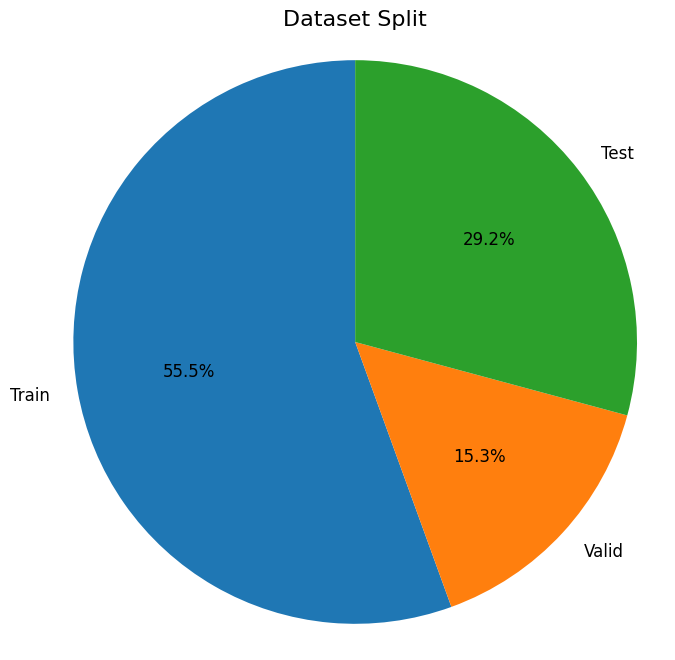

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# 获取训练、验证和测试集数据
train_data = dataset.prepare("train")
valid_data = dataset.prepare("valid")
test_data = dataset.prepare("test")

# 获取数据集样本数量
data_lengths = {
    "train": len(train_data),
    "valid": len(valid_data),
    "test": len(test_data)
}

# 将样本长度数据制作成 DataFrame（非必要，仅用于额外展示）
data_lengths_df = pd.DataFrame(list(data_lengths.items()), columns=['Dataset', 'Samples'])

# 绘制饼图
labels = ['Train', 'Valid', 'Test']  
sizes = [data_lengths['train'], data_lengths['valid'], data_lengths['test']]  # 动态比例

plt.figure(figsize=(8, 8))  # 设置饼图的画布大小
plt.pie(sizes, labels=labels, autopct='%1.1f%%', textprops={'fontsize': 12}, startangle=90)
plt.title("Dataset Split", fontsize=16)  # 图标题
plt.axis('equal')  # 保证饼图是圆的
plt.show()

<Figure size 1200x1200 with 0 Axes>

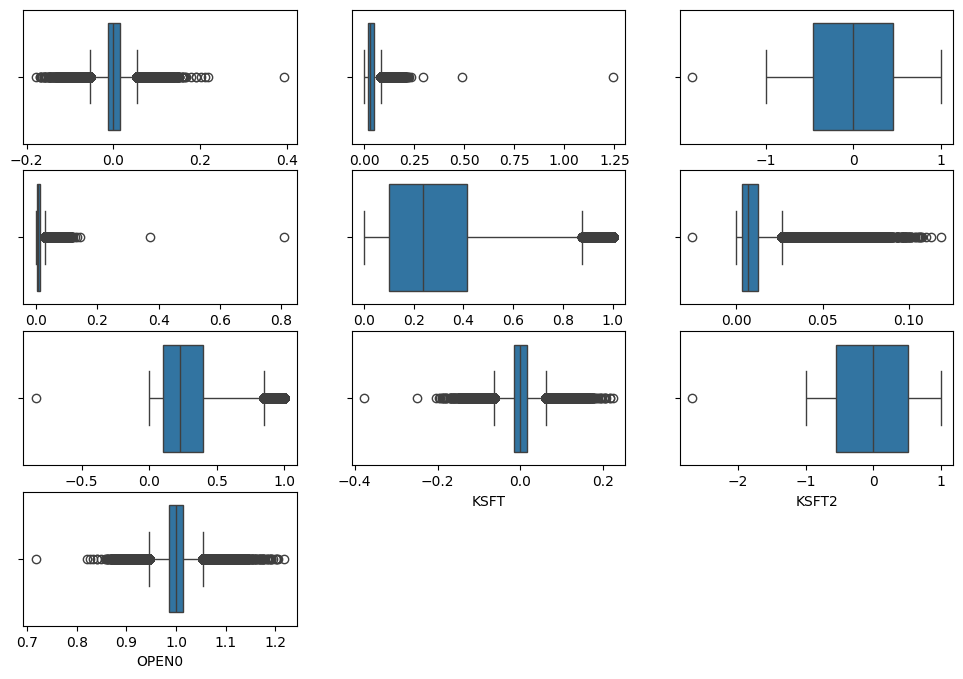

In [15]:
# Adjust the subplot grid size to accommodate all items
all_columns = list(train_data.columns)
columns = all_columns[:10]

plt.figure(figsize=(12, 12))
num_cols = len(columns)
num_rows = (num_cols // 3) + (num_cols % 3 > 0)  # Calculate the number of rows needed
plt.figure(figsize=(12, 4 * num_rows))  # Adjust figure height based on number of rows
for i, col in enumerate(columns):
    plt.subplot(num_rows, 3, i + 1)  # Adjust subplot indexing
    sns.boxplot(x=col, data=data)
plt.show()

DATA DIMENSIONS ANALYSIS
Time Range: 2017-01-03 00:00:00 to 2020-07-31 00:00:00
Total Observations: 261,300
Unique Trading Days: 871
Unique Stocks: 452
Features: ['$close', '$volume']

Missing Trading Days: 64/935 (6.8%)


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

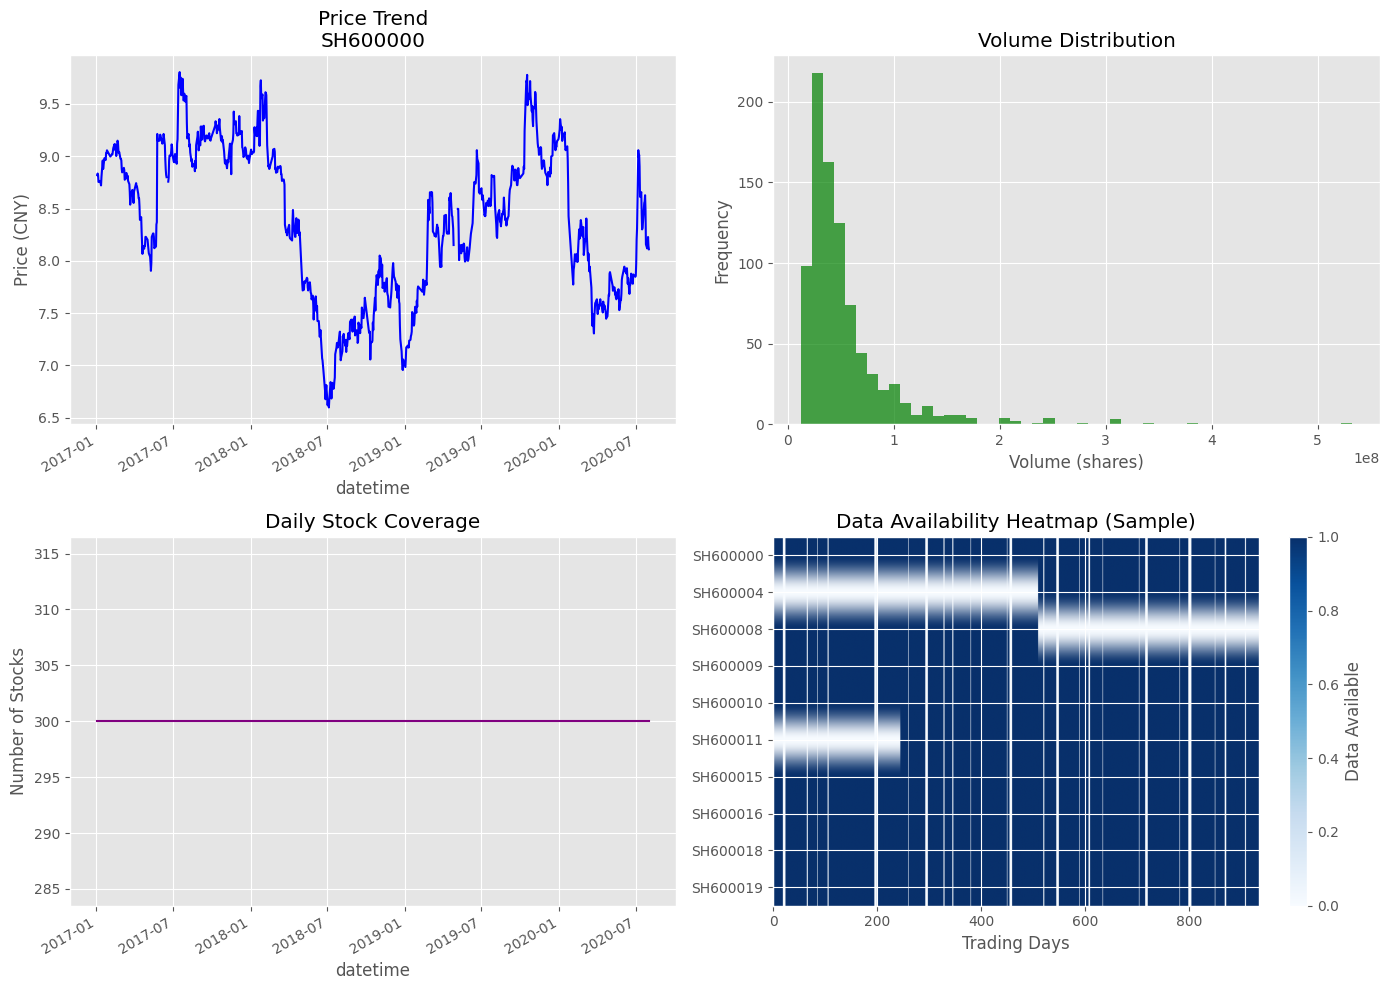

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from qlib.data import D

def show_data_dimensions(market="csi300", start_time="2017-01-01", end_time="2020-08-01"):
    # 获取基础数据
    instruments = D.instruments(market)
    df = D.features(instruments, ['$close', '$volume'], start_time=start_time, end_time=end_time)
    
    # 数据维度分析
    print("="*50 + "\nDATA DIMENSIONS ANALYSIS\n" + "="*50)
    print(f"Time Range: {df.index.get_level_values('datetime').min()} to {df.index.get_level_values('datetime').max()}")
    print(f"Total Observations: {len(df):,}")
    print(f"Unique Trading Days: {df.index.get_level_values('datetime').nunique():,}")
    print(f"Unique Stocks: {df.index.get_level_values('instrument').nunique():,}")
    print(f"Features: {df.columns.tolist()}")
    
    # 时间序列完整性检查
    date_range = pd.date_range(start=start_time, end=end_time, freq='B')
    missing_dates = date_range.difference(df.index.get_level_values('datetime').unique())
    print(f"\nMissing Trading Days: {len(missing_dates)}/{len(date_range)} ({len(missing_dates)/len(date_range):.1%})")
    
    # 可视化展示
    plt.figure(figsize=(14, 10))
    
    # 1. 价格和成交量趋势
    plt.subplot(2, 2, 1)
    sample_stock = df.index.get_level_values('instrument')[0]
    sample_data = df.xs(sample_stock, level='instrument')
    sample_data['$close'].plot(title=f"Price Trend\n{sample_stock}", color='blue')
    plt.ylabel('Price (CNY)')
    
    # 2. 成交量分布
    plt.subplot(2, 2, 2)
    sample_data['$volume'].plot(kind='hist', bins=50, title="Volume Distribution", color='green', alpha=0.7)
    plt.xlabel('Volume (shares)')
    
    # 3. 股票覆盖数量变化
    plt.subplot(2, 2, 3)
    stock_counts = df.groupby(level='datetime').size()
    stock_counts.plot(title="Daily Stock Coverage", color='purple')
    plt.ylabel('Number of Stocks')
    
    # 4. 数据缺失热力图
    plt.subplot(2, 2, 4)
    sample_stocks = df.index.get_level_values('instrument').unique()[:10]  # 展示前10只股票
    presence_matrix = pd.DataFrame(
        index=pd.date_range(start_time, end_time, freq='B'),
        columns=sample_stocks
    )
    for stock in sample_stocks:
        stock_dates = df.xs(stock, level='instrument').index
        presence_matrix[stock] = presence_matrix.index.isin(stock_dates)
    plt.imshow(presence_matrix.T, cmap='Blues', aspect='auto')
    plt.title("Data Availability Heatmap (Sample)")
    plt.xlabel("Trading Days")
    plt.yticks(range(len(sample_stocks)), sample_stocks)
    plt.colorbar(label='Data Available')
    
    plt.tight_layout()
    plt.show()

# 执行分析
show_data_dimensions()

<Figure size 1200x1200 with 0 Axes>

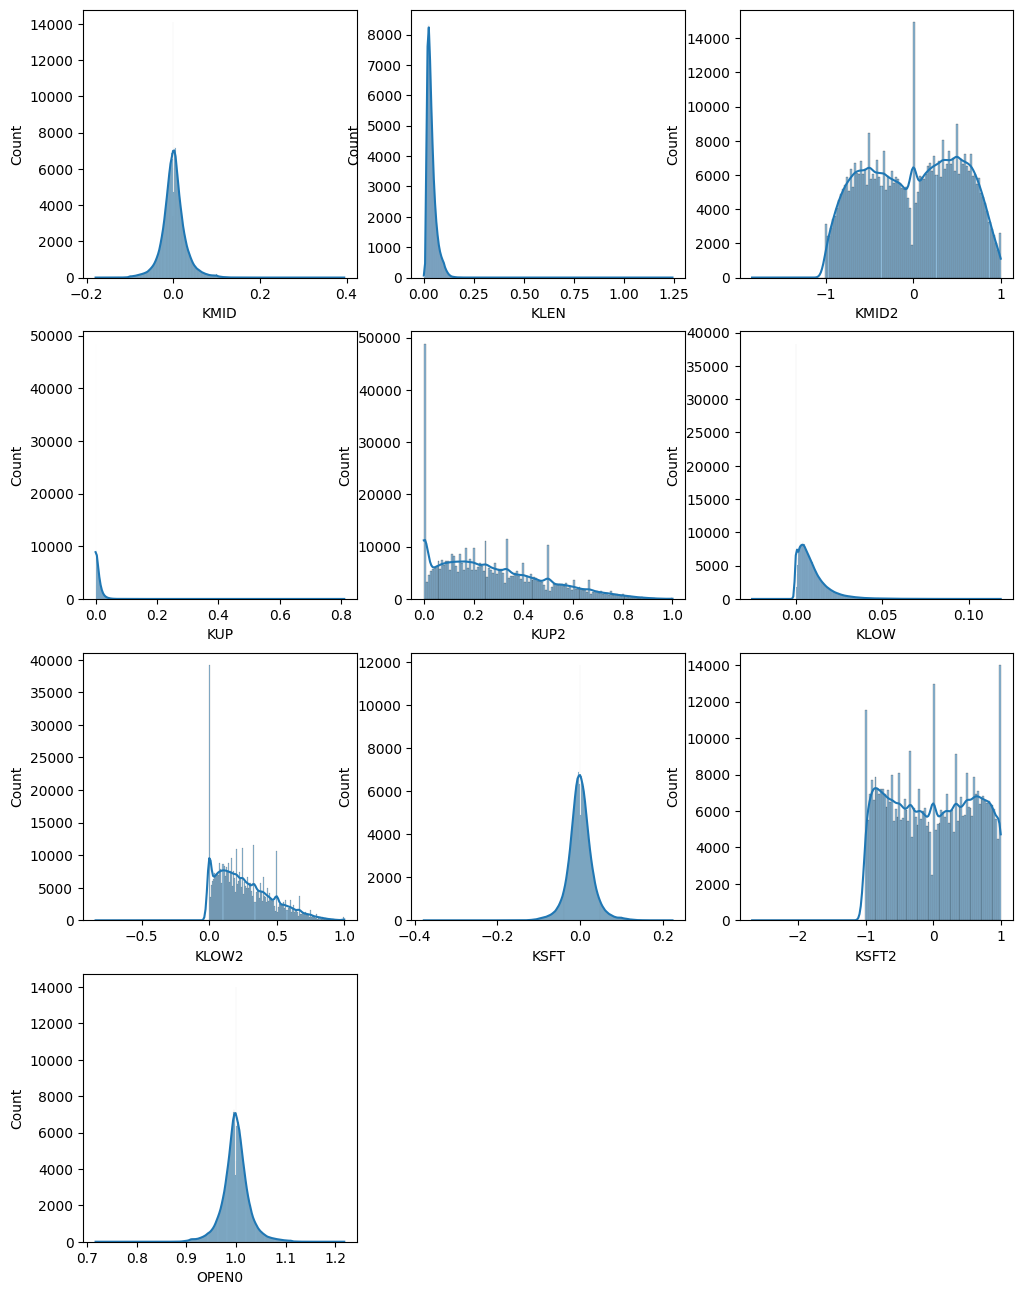

In [16]:
# Adjust the subplot grid size to accommodate all items
plt.figure(figsize=(12, 12))
num_cols = len(columns)
num_rows = (num_cols // 3) + (num_cols % 3 > 0)  # Calculate the number of rows needed
plt.figure(figsize=(12, 4 * num_rows))  # Adjust figure height based on number of rows
for i, col in enumerate(columns):
    plt.subplot(num_rows, 3, i + 1)  # Adjust subplot indexing
    sns.histplot(x=col, data=data, kde=True)
plt.show()

# The Heatmap

In [27]:
# 获取某只示范股票的全维度数据（如贵州茅台）
stock_code = "600519.SH"
data_fields = ["$open", "$close", "$high", "$low", "$volume", "$factor"]  # 包含复权因子
stock_data = D.features([stock_code], data_fields, start_time="2017-01-01", end_time="2020-08-01")

# 打印前5行数据
print("="*50 + "\nBASIC PRICE & VOLUME DATA\n" + "="*50)
print(stock_data.head())

# 关键统计量
print("\nSTATISTICAL SUMMARY:")
print(stock_data.describe())

BASIC PRICE & VOLUME DATA
Empty DataFrame
Columns: [$open, $close, $high, $low, $volume, $factor]
Index: []

STATISTICAL SUMMARY:
       $open  $close  $high  $low  $volume  $factor
count    0.0     0.0    0.0   0.0      0.0      0.0
mean     NaN     NaN    NaN   NaN      NaN      NaN
std      NaN     NaN    NaN   NaN      NaN      NaN
min      NaN     NaN    NaN   NaN      NaN      NaN
25%      NaN     NaN    NaN   NaN      NaN      NaN
50%      NaN     NaN    NaN   NaN      NaN      NaN
75%      NaN     NaN    NaN   NaN      NaN      NaN
max      NaN     NaN    NaN   NaN      NaN      NaN


Standard Scaling and Label Encoding

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

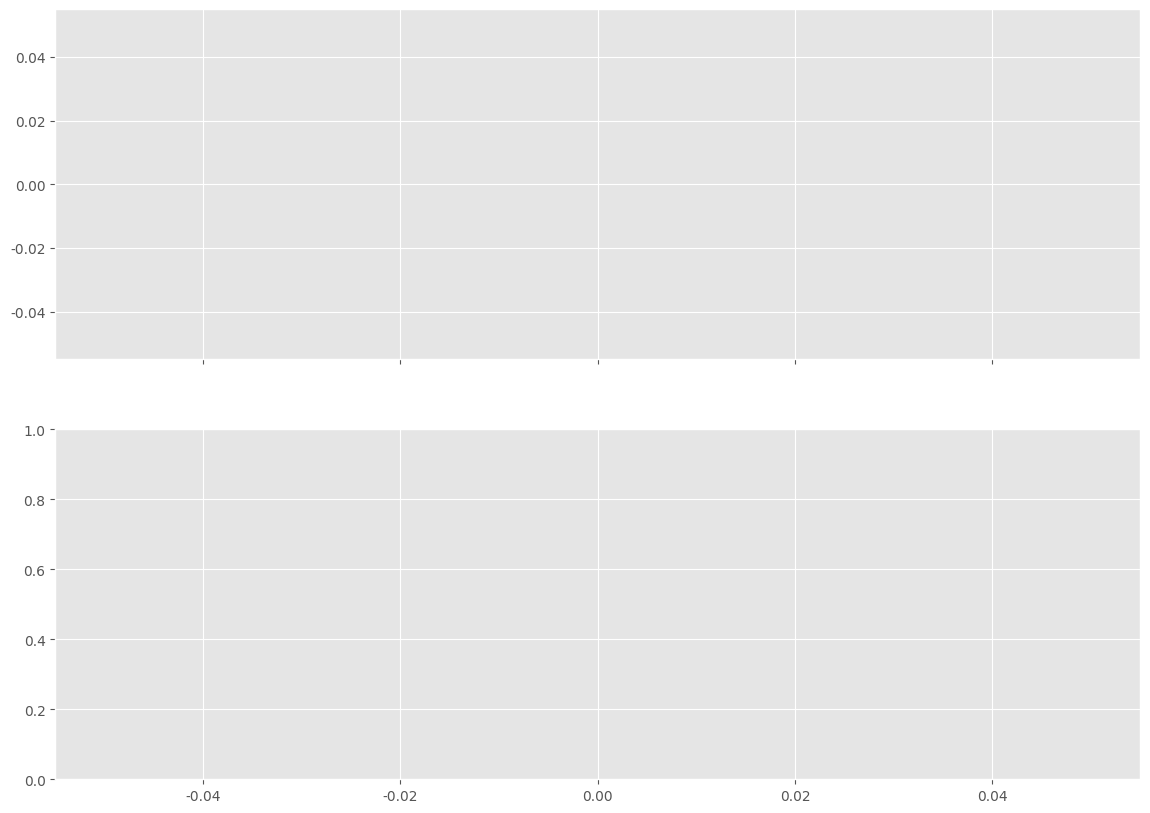

In [28]:
import matplotlib.dates as mdates

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# K线图（价格）
ax1.plot(stock_data['$close'], label='Close', color='blue')
ax1.fill_between(stock_data.index, 
                stock_data['$low'], 
                stock_data['$high'],
                alpha=0.3, color='gray')
ax1.set_title(f"{stock_code} Price & Volume")
ax1.set_ylabel('Price (CNY)')
ax1.legend()

# 成交量柱状图
ax2.bar(stock_data.index, stock_data['$volume']/1e6, 
        width=1, color='green', alpha=0.6)
ax2.set_ylabel('Volume (Million Shares)')
ax2.xaxis.set_major_locator(mdates.YearLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.tight_layout()
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


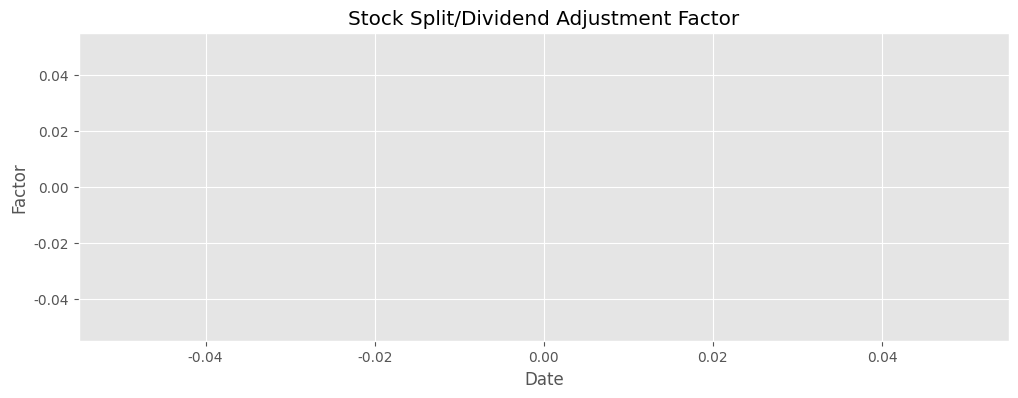

In [29]:
# 复权因子可视化
plt.figure(figsize=(12, 4))
plt.plot(stock_data['$factor'], label='Adjustment Factor', color='red')
plt.title("Stock Split/Dividend Adjustment Factor")
plt.ylabel('Factor')
plt.xlabel('Date')
plt.grid(True)

# 标注重大调整日期
large_adjustments = stock_data[stock_data['$factor'].diff().abs() > 0.1]
for date, row in large_adjustments.iterrows():
    plt.annotate(f"Split: {row['$factor']:.2f}x", 
                (date, row['$factor']),
                xytext=(10, 10), 
                textcoords='offset points',
                arrowprops=dict(arrowstyle="->"))
plt.show()

In [30]:
from qlib.data import get_calendar

# 获取交易日历
calendar = get_calendar('SH')  # 上海交易所
print("="*50 + "\nTRADING CALENDAR\n" + "="*50)
print(f"First Trading Day: {calendar[0]}")
print(f"Last Trading Day: {calendar[-1]}")
print(f"Total Trading Days: {len(calendar)}")

# 可视化假期分布
years = pd.Series(calendar).dt.year.value_counts().sort_index()
plt.bar(years.index, years.values)
plt.title("Trading Days per Year")
plt.xlabel("Year")
plt.ylabel("Days")
plt.show()

ImportError: cannot import name 'get_calendar' from 'qlib.data' (/home/24039378g/QuantProject/QLIB/qlib/data/__init__.py)

In [33]:
import pandas as pd
from qlib.data import D

# 获取示范股票数据（贵州茅台）
symbol = "600519.SH"
data_fields = ["$open", "$close", "$high", "$low", "$volume", "$factor"]
data = D.features([symbol], data_fields, start_time="2020-01-01", end_time="2020-12-31")

print("="*60)
print("BASIC PRICE & VOLUME DATA")
print("="*60)
print(data.head(3))  # 展示前3天数据

# 关键统计量
print("\nSTATISTICAL SUMMARY:")
print(data[["$open", "$close", "$high", "$low", "$volume"]].describe().round(2))

BASIC PRICE & VOLUME DATA
Empty DataFrame
Columns: [$open, $close, $high, $low, $volume, $factor]
Index: []

STATISTICAL SUMMARY:
       $open  $close  $high  $low  $volume
count    0.0     0.0    0.0   0.0      0.0
mean     NaN     NaN    NaN   NaN      NaN
std      NaN     NaN    NaN   NaN      NaN
min      NaN     NaN    NaN   NaN      NaN
25%      NaN     NaN    NaN   NaN      NaN
50%      NaN     NaN    NaN   NaN      NaN
75%      NaN     NaN    NaN   NaN      NaN
max      NaN     NaN    NaN   NaN      NaN


In [35]:
print("\nADJUSTMENT FACTOR ANALYSIS:")
print(f"Initial Factor: {data['$factor'].iloc[0]:.4f}")
print(f"Final Factor: {data['$factor'].iloc[-1]:.4f}")
print(f"Total Adjustments: {len(data[data['$factor'].diff().abs() > 0.01])}")

# 可视化复权事件
plt.figure(figsize=(10,4))
plt.plot(data['$factor'], marker='o', markersize=3)
plt.title(f"{symbol} Adjustment Factor Timeline")
plt.ylabel("Factor")
plt.grid(True)


ADJUSTMENT FACTOR ANALYSIS:


IndexError: single positional indexer is out-of-bounds

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# Step 1: Preprocess Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 2: Define GPR Kernel
kernel = ConstantKernel(1.0, constant_value_bounds=(0.1, 10)) * \
         RBF(1.0, length_scale_bounds=(0.1, 10.0)) + \
         WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e1))

# Step 3: Train GPR Model
gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True)
gpr.fit(X_train_scaled, y_train)

# Step 4: Make Predictions
y_pred, y_std = gpr.predict(X_test_scaled, return_std=True)

# Step 5: Post-Processing for Classification
# Round predictions to nearest integer and clip to valid range [0, 1, 2, 3]
y_pred_class = y_pred.round().clip(0, 3).astype(int)

# Step 6: Evaluate Classification Accuracy
accuracy = accuracy_score(y_test, y_pred_class)
print(f"Classification Accuracy: {accuracy:.2f}")

# Optional: Generate a Detailed Classification Report
print(classification_report(y_test, y_pred_class))

Classification Accuracy: 0.34
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        26
         1.0       0.00      0.00      0.00        86
         2.0       0.34      1.00      0.51        94
         3.0       0.00      0.00      0.00        67

    accuracy                           0.34       273
   macro avg       0.09      0.25      0.13       273
weighted avg       0.12      0.34      0.18       273



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

# KNN Operation

In [24]:
from sklearn.neighbors import KNeighborsClassifier

test_scores = []
train_scores = []

for i in range(1, 15):
    knn = KNeighborsClassifier(i)
    knn.fit(X_train, y_train)
    train_scores.append(knn.score(X_train, y_train))
    test_scores.append(knn.score(X_test, y_test))

In [25]:
max_train_score = max(train_scores)
train_scores_index = [i for i, v in enumerate(train_scores) if v == max_train_score]
print("Max Train score {}% and k = {}".format(max_train_score*100, list(map(lambda x: x+1, train_scores_index))))

Max Train score 100.0% and k = [1]


In [26]:
max_test_score = max(test_scores)
test_scores_index = [i for i, v in enumerate(test_scores) if v == max_test_score]
print("Max Test score {}% and k = {}".format(max_test_score*100, list(map(lambda x: x+1, test_scores_index))))

Max Test score 35.53113553113553% and k = [12, 13]


In [27]:
knn = KNeighborsClassifier(13)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.3553113553113553

In [28]:
from sklearn.metrics import confusion_matrix
y_pred = knn.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[ 2, 11, 11,  2],
       [ 4, 44, 26, 12],
       [ 0, 48, 43,  3],
       [ 0, 33, 26,  8]], dtype=int64)

In [29]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.33      0.08      0.12        26
         1.0       0.32      0.51      0.40        86
         2.0       0.41      0.46      0.43        94
         3.0       0.32      0.12      0.17        67

    accuracy                           0.36       273
   macro avg       0.35      0.29      0.28       273
weighted avg       0.35      0.36      0.33       273

